In [14]:
import matplotlib.pyplot as plt
from codex.ops import tile_generator
from codex.ops import tile_crop
from codex.ops import drift_compensation
from codex.ops import best_focus
from codex.ops import deconvolution
from codex import config as codex_config
from flowdec.nb import utils as nb_utils
from flowdec import data as fd_data
from codex import simulation
import os

Instructions for updating:
Use the retry module or similar alternatives.


In [6]:
import numpy as np
tiles = np.array_split(np.arange(25), 3)
tiles

[array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 9, 10, 11, 12, 13, 14, 15, 16]),
 array([17, 18, 19, 20, 21, 22, 23, 24])]

In [2]:
img = fd_data.load_celegans_channel('FITC').data
img = img[slice(0, 160, 10)]
img.shape

(11, 712, 672)

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/eczech/anaconda3/envs/codex/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/eczech/anaconda3/envs/codex/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


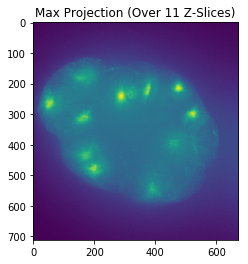

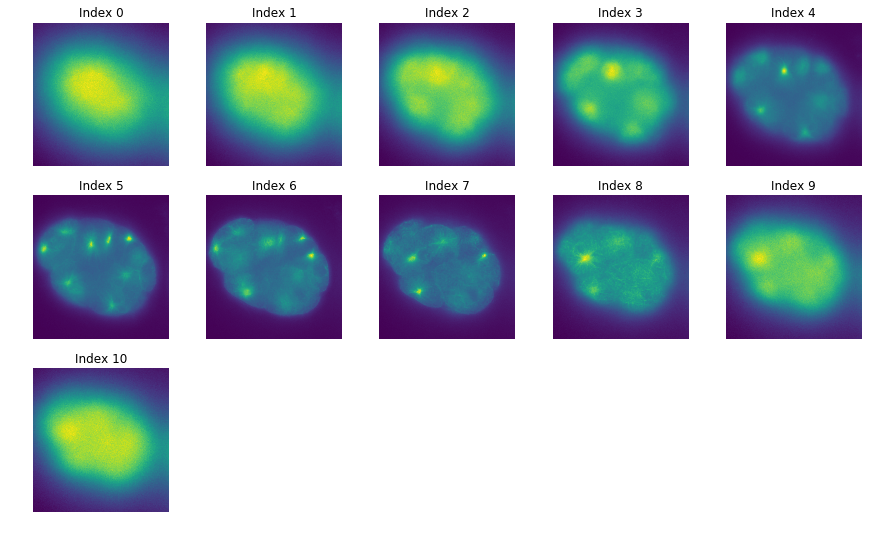

In [3]:
nb_utils.plot_img_preview(img)

In [4]:
#tile, config, info = simulation.load_simulated_bars_experiment(blur=True)
#tile, config, info = simulation.load_celegans_experiment()
tile, config, info = simulation.experiment_from_img(img)

In [5]:
tile.shape

(3, 11, 4, 772, 702)

In [6]:
with drift_compensation.CodexDriftCompensator(config) as op:
    tile_aligned = op.run(tile)

tile_aligned.shape

INFO:codex.ops.drift_compensation:Calculating drift translations
DEBUG:codex.ops.drift_compensation:Calculating drift translation for reference cycle 0, comparison cycle 1
DEBUG:codex.ops.drift_compensation:Calculating drift translation for reference cycle 0, comparison cycle 2
INFO:codex.ops.drift_compensation:Applying drift translations
DEBUG:codex.ops.drift_compensation:Applying translation [0. 0. 0.] to cycle 0
DEBUG:codex.ops.drift_compensation:Applying translation [  5   5 -15] to cycle 1
DEBUG:codex.ops.drift_compensation:Applying translation [  5   5 -15] to cycle 2


(3, 11, 4, 772, 702)

In [67]:
with best_focus.CodexFocalPlaneSelector(config) as op:
    focus_tile, best_z, classifications, probabilities = op.run(tile)
    print(best_z)

INFO:root:Using model_id = 0.
INFO:tensorflow:Restoring parameters from /Users/eczech/.codex/cache/best_focus/model/model.ckpt-1000042
INFO:tensorflow:Restoring parameters from /Users/eczech/.codex/cache/best_focus/model/model.ckpt-1000042
INFO:root:Model restored from /Users/eczech/.codex/cache/best_focus/model/model.ckpt-1000042.
INFO:codex.ops.best_focus:Best focal plane: z = 0 (scores: [9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 10, 10, 10, 10, 10, 10])
0


In [69]:
# import pandas as pd
# import numpy as np
# df = pd.DataFrame(probabilities)
# df.index.name = 'z-planes'
# df.columns.name = 'class'
# df[10].plot()

In [14]:
import imp
imp.reload(tile_crop)

<module 'codex.ops.tile_crop' from '/Users/eczech/repos/hammer/codex/python/pipeline/codex/ops/tile_crop.py'>

In [7]:
config.tile_height(), config.tile_width()

(712, 672)

In [8]:
with tile_crop.CodexTileCrop(config) as op:
    crop_tile = op.run(tile_aligned)
crop_tile.shape

(3, 11, 4, 712, 672)

In [9]:
with deconvolution.CodexDeconvolution(config, n_iter=3) as op:
    decon_tile = op.run(crop_tile)
decon_tile.shape

DEBUG:codex.ops.deconvolution:Generating PSFs from experiment configuration file


(3, 11, 4, 712, 672)

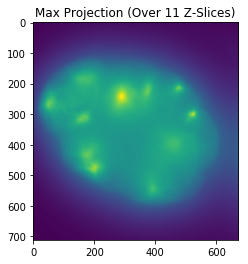

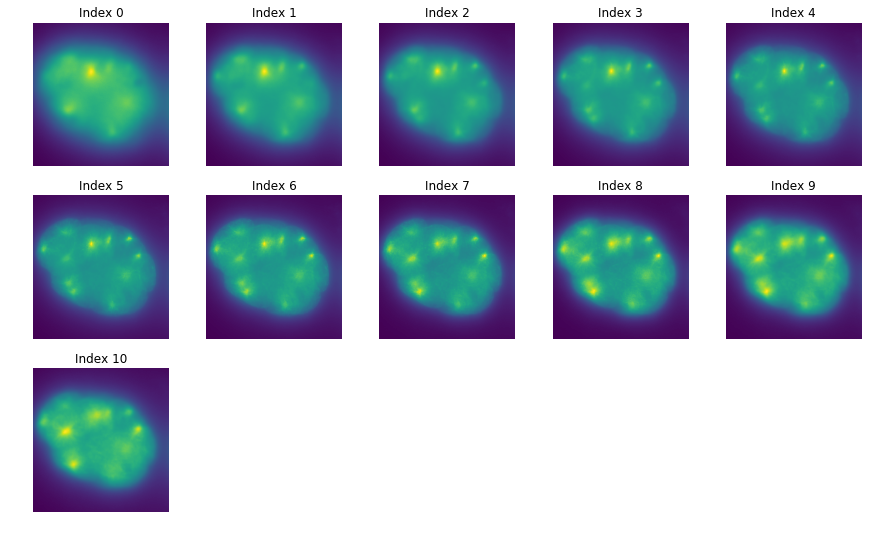

In [11]:
nb_utils.plot_img_preview(decon_tile[0, :, 0, :, :])